# Parkinsons Disease Detection with FBANKs and ECAPA-TDNN

using:

- Adam optimizer with linear schedular.
- Global normalization; computes a single normalization vector for all the dataset
- Negative LogLikelihood loss.




#### ECAPA-TDNN (Emphasized Channel Attention, Propagation, and Aggregation in Time Delay Neural Network)[1]: 
It is a deep-learning model for speaker verification. ECAPA-TDNN is an enhanced version of TDNN that improves speaker and speech representation by integrating:

- Emphasized channel attention (SE (Squeeze and Excitation) blocks) to focus on important frequency bands,

- Propagation of multi-scale features via Res2Net-style residual connections, and

- Aggregation of global statistics (mean + std) over time using statistics pooling.

These enhancements help ECAPA-TDNN capture both local and global temporal dynamics in speech, producing robust, fixed-length embeddings for variable-length audio.

[1] [[2005.07143] ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification](https://arxiv.org/pdf/2005.07143

notes:
- ECAPA-TDNN uses Res2Net blocks, which split and process channels with different receptive fields in parallel — this gives multi-scale context without needing large kernels.

- Dilations in ECAPA are already used to expand the receptive field efficiently.

- Attention mechanisms in ECAPA (SE blocks) help the model focus on relevant information dynamically, which again reduces the need for large static kernels.

In [ ]:
import speechbrain

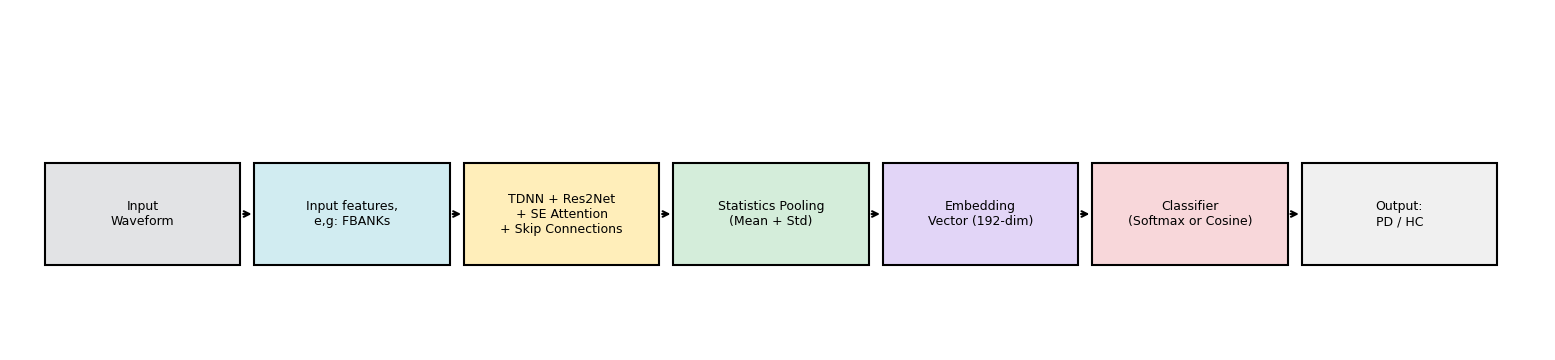

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_block(ax, text, xy, width=2.8, height=1.2, color="#cce5ff"):
    x, y = xy
    box = Rectangle((x, y), width, height, edgecolor='black', facecolor=color, lw=1.5)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, ha='center', va='center', fontsize=9, wrap=True)

def draw_arrow(ax, start, end):
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', lw=1.5))

fig, ax = plt.subplots(figsize=(16, 4))
ax.set_xlim(0, 22)
ax.set_ylim(0, 4)
ax.axis('off')

# Coordinates for blocks (left to right)
blocks = [
    ("Input\nWaveform", (0.5, 1), "#e2e3e5"),
    ("Input features,\ne,g: FBANKs", (3.5, 1), "#d1ecf1"),
    ("TDNN + Res2Net\n+ SE Attention\n+ Skip Connections", (6.5, 1), "#ffeeba"),
    ("Statistics Pooling\n(Mean + Std)", (9.5, 1), "#d4edda"),
    ("Embedding\nVector (192-dim)", (12.5, 1), "#e2d5f7"),
    ("Classifier\n(Softmax or Cosine)", (15.5, 1), "#f8d7da"),
    ("Output:\nPD / HC", (18.5, 1), "#f0f0f0"),
]

# Draw blocks
for text, pos, color in blocks:
    draw_block(ax, text, pos, color=color)

# Draw arrows between blocks
for i in range(len(blocks) - 1):
    x_start = blocks[i][1][0] + 2.8
    x_end = blocks[i+1][1][0]
    draw_arrow(ax, (x_start, 1.6), (x_end, 1.6))

plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.1)

# plt.savefig("ecapa_tdnn_diagram.png", dpi=300, bbox_inches='tight')
plt.show()


## imports

In [1]:
from plot_tensorboard import plot_training
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import sys


2025-04-25 18:40:16.547771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 18:40:16.940913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 18:40:17.038870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 18:40:18.060326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 18:41:29.534209: W tensorflow/comp

In [19]:
# !rm -rf __pycache__

## Transfer Learning: Finetuning the Pretrained ECAPA-TDNN

The ECAPA-TDNN pretrained model is pretrained on VoxCeleb for speaker recognition.

### hparams file

In [20]:
%%file hparams_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>

# Load pretrained embedding module
# Note: in this case, we pre-train with the ECAPA-TDNN model trained on voxceleb
# for speaker-id (this leads to a performance improvement).
embedding_model_path: speechbrain/spkrec-ecapa-voxceleb/embedding_model.ckpt

# Pretrained ECAPA embeddings from SpeakerID on VoxCeleb
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        embedding_model: !ref <embedding_model>
    paths:
        embedding_model: !ref <embedding_model_path>


Overwriting hparams_ecapatdnn_fbanks.yaml


### train file

In [21]:
%%file train_ecapatdnn_fbanks.py

#!/usr/bin/env python3
import os
import sys

import torchaudio
import torch
# from common_language_prepare import prepare_common_language
from hyperpyyaml import load_hyperpyyaml

import speechbrain as sb
from speechbrain.utils.logger import get_logger
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np

"""Recipe for training a LID system with CommonLanguage.

To run this recipe, do the following:
> python train.py hparams/train_ecapa_tdnn.yaml

Author
------
 * Mirco Ravanelli 2021
 * Pavlo Ruban 2021
"""

# logger = get_logger(__name__)


# Brain class for Language ID training
class DetectorBrain(sb.Brain):
    def prepare_features(self, wavs, stage):
        """Prepare the features for computation.

        Arguments
        ---------
        wavs : tuple
            Input signals (tensor) and their relative lengths (tensor).
        stage : sb.Stage
            The current stage of training.

        Returns
        -------
        feats : torch.Tensor
            Computed features.
        lens : torch.Tensor
            The length of the corresponding features.
        """
        wavs, lens = wavs

        # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm_input(feats, lens)

        return feats, lens

    def compute_forward(self, batch, stage):
        """Runs all the computation of that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            torch.Tensor that contains the posterior probabilities over the N classes.
        """

        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)

        # Compute features, embeddings and output
        feats, lens = self.prepare_features(batch.sig, stage)
        embeddings = self.modules.embedding_model(feats)
        outputs = self.modules.classifier(embeddings)

        return outputs, lens

    def compute_objectives(self, inputs, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        inputs : tensors
            The output tensors from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        predictions, lens = inputs

        targets = batch.detection_id_encoded.data
        loss = self.hparams.compute_cost(predictions, targets)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, targets, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = targets.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)
        if stage == sb.Stage.TEST:
            # print('test y_true= ', y_true)
            # print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=targets, lengths=lens
        )

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_common_language` to have been called before this,
    so that the `train.csv`, `valid.csv`,  and `test.csv` manifest files
    are available.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "dev" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'lang01': 0, 'lang02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, _ = torchaudio.load(wav)
        sig = sig.transpose(0, 1).squeeze(1)

        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }

    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":
    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test" and label_encoder
    datasets, label_encoder = dataio_prep(hparams)

    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    # print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_options"],
        valid_loader_kwargs=hparams["test_dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["test_dataloader_options"],
    )
    

Overwriting train_ecapatdnn_fbanks.py


In [7]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/full_dataset/fbank/1986

# Run Training
!{sys.executable} train_ecapatdnn_fbanks.py hparams_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/full_dataset/fbank/1986
2025-04-20 21:38:14.884941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 21:38:14.903648: E external/local_xla/xla/stream_executor/cuda/cud

The output train_log file when running the run.sh file:

```
Epoch: 1, lr: 1.00e-04 - train loss: 4.20, train acc: 5.88e-01 - valid loss: 6.27, valid acc: 5.83e-01, valid error: 4.17e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.17, train acc: 6.36e-01 - valid loss: 4.60, valid acc: 5.73e-01, valid error: 4.27e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.34, train acc: 6.67e-01 - valid loss: 2.43, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 4, lr: 8.07e-05 - train loss: 1.88, train acc: 7.10e-01 - valid loss: 1.75, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 5, lr: 7.43e-05 - train loss: 1.80, train acc: 6.79e-01 - valid loss: 1.98, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 6, lr: 6.79e-05 - train loss: 1.62, train acc: 7.10e-01 - valid loss: 1.04, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.39, train acc: 7.13e-01 - valid loss: 1.67, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 8, lr: 5.50e-05 - train loss: 1.40, train acc: 7.53e-01 - valid loss: 1.94, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.26, train acc: 7.33e-01 - valid loss: 2.55, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.38, train acc: 7.45e-01 - valid loss: 1.23, valid acc: 8.54e-01, valid error: 1.46e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.20, train acc: 7.58e-01 - valid loss: 1.85, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.32, train acc: 7.55e-01 - valid loss: 1.61, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.25, train acc: 7.55e-01 - valid loss: 8.39e-01, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch: 14, lr: 1.64e-05 - train loss: 1.21, train acc: 7.67e-01 - valid loss: 2.25, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 15, lr: 1.00e-05 - train loss: 1.25, train acc: 7.44e-01 - valid loss: 1.17, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch loaded: 13, 
 Per Class Accuracy: 
0: 0.979
1: 0.737, 
 Confusion Matrix: 
[[47  1]
 [10 28]]
 - test loss: 1.50, test acc: 8.72e-01, test error: 1.28e-01
```

'PD' => 0

'HC' => 1


### plot train/valid loss/accuracy during training

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


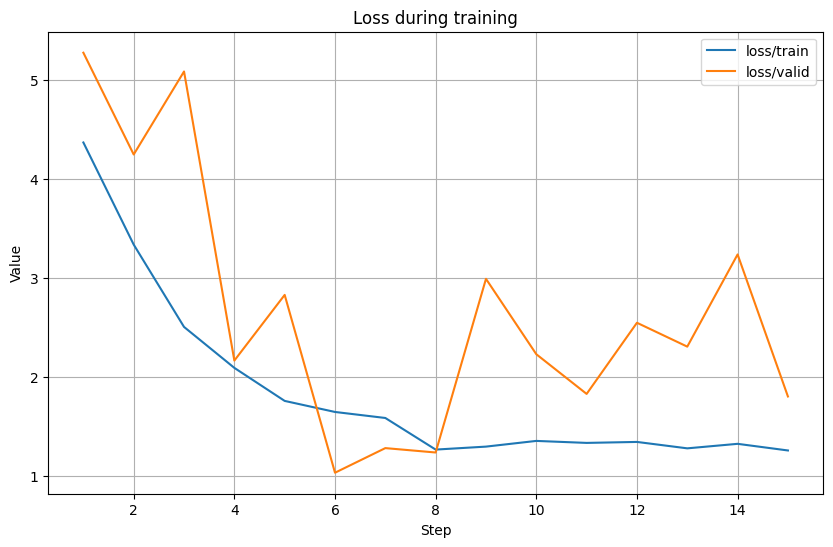

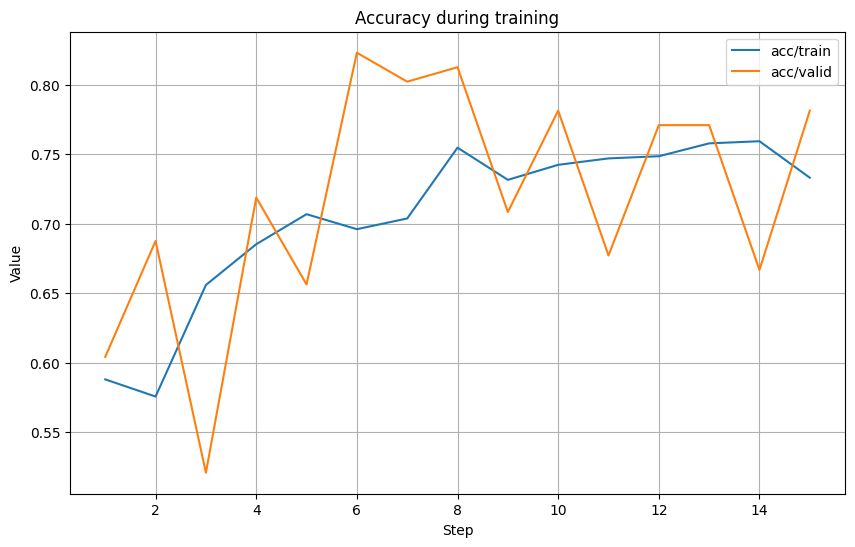

In [5]:

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/full_dataset/fbank/1986/tb_logs/events.out.tfevents.1745559640.ul-val-pr-cpc02.l.ul.ca.2985800.0"
plot_training(event_file)



## Training from scratch using FBANKs input features

### hparams file

In [22]:
%%file hparams_fromscratch_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Overwriting hparams_fromscratch_ecapatdnn_fbanks.yaml


We can use the same train file for the pretrained model above

In [8]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/full_dataset/fbank/1986

# Run Training
!{sys.executable} train_ecapatdnn_fbanks.py hparams_fromscratch_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/full_dataset/fbank/1986
2025-04-22 19:16:24.456940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 19:16:24.474439: E external/local_xla/xla/stream_execu

train log output:
```
Epoch: 1, lr: 1.00e-04 - train loss: 4.20, train acc: 5.88e-01 - valid loss: 6.27, valid acc: 5.83e-01, valid error: 4.17e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.06, train acc: 6.60e-01 - valid loss: 3.18, valid acc: 6.56e-01, valid error: 3.44e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.58, train acc: 6.77e-01 - valid loss: 2.66, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.02, train acc: 6.91e-01 - valid loss: 1.85, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch: 5, lr: 7.43e-05 - train loss: 1.84, train acc: 6.94e-01 - valid loss: 2.02, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 6, lr: 6.79e-05 - train loss: 1.71, train acc: 6.99e-01 - valid loss: 1.18, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.56, train acc: 7.11e-01 - valid loss: 1.49, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch: 8, lr: 5.50e-05 - train loss: 1.47, train acc: 7.50e-01 - valid loss: 1.02, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.50, train acc: 7.24e-01 - valid loss: 1.71, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.63, train acc: 7.30e-01 - valid loss: 1.68, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.35, train acc: 7.41e-01 - valid loss: 1.94, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.35, train acc: 7.52e-01 - valid loss: 8.02e-01, valid acc: 8.85e-01, valid error: 1.15e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.26, train acc: 7.52e-01 - valid loss: 1.22, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 14, lr: 1.64e-05 - train loss: 1.32, train acc: 7.62e-01 - valid loss: 1.87, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 15, lr: 1.00e-05 - train loss: 1.36, train acc: 7.39e-01 - valid loss: 1.04, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch loaded: 12, 
 Per Class Accuracy: 
0: 0.938
1: 0.632, 
 Confusion Matrix: 
[[45  3]
 [14 24]]
 - test loss: 2.10, test acc: 8.02e-01, test error: 1.98e-01
```

'PD' => 0

'HC' => 1


### plot training loss

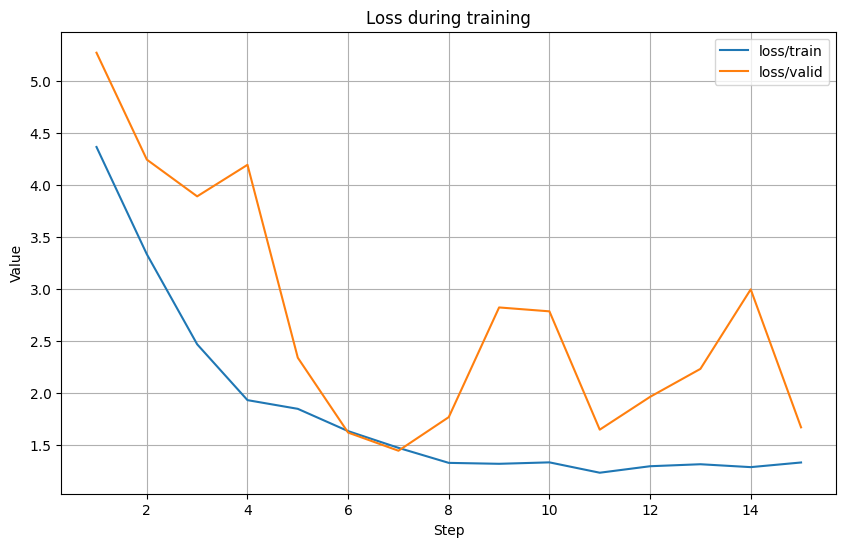

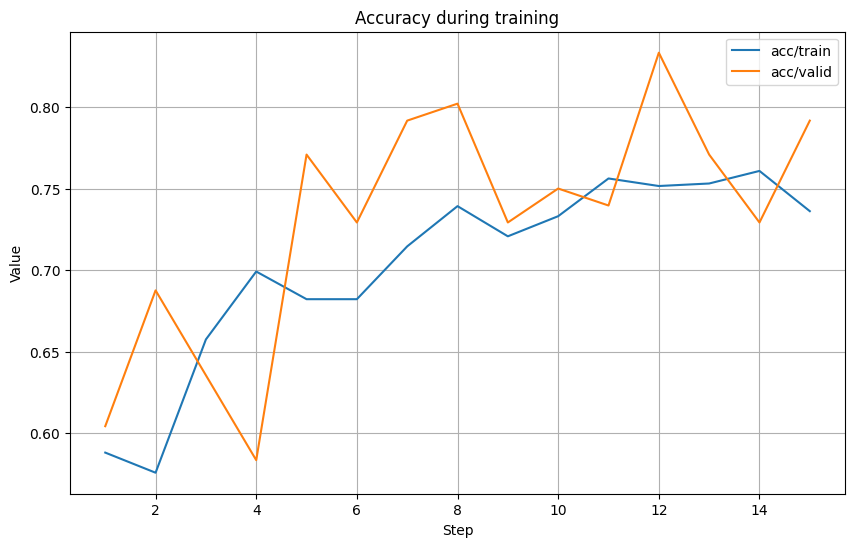

In [6]:

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/full_dataset/fbank/1986/tb_logs/events.out.tfevents.1745559640.ul-val-pr-cpc02.l.ul.ca.2985028.0"
plot_training(event_file)



## Add Data Augmentation - ECAPA-TDNN from scratch

it doesn't improve the performance

1- speed perturbation
2- SpecAugment (time/frequecy dropout)

(1) **Speed Perturbation**

- Alters the speed of the audio by ±5% and keeps the original (100%) as well.

- Values: [95, 100, 105] represent speed in percentage of original.

- Effect: Changes tempo and pitch slightly, which helps the model generalize to different speaking rates.

(2) **DropFreq**

- Randomly zeros out frequency bands during training.

- Parameters:

    * drop_freq_count_low to high: Drops 1 to 3 bands per sample.

    * drop_freq_width: Each dropped band is 5% of total frequency range.

- Effect: Encourages robustness to frequency domain noise or channel variability.

(3) **DropChunk (drop_time)**

- Drops (zeros out) random time intervals from the waveform.

- Parameters:

    * drop_length_low/high: Each drop lasts 1000–2000 samples (about 0.06–0.125 sec at 16kHz).

    * drop_count_low/high: 1 to 5 such drops per audio.

- Effect: Simulates signal loss or interruptions, improving model resilience.

- Time/Frequency dropout helps to train the model to learen robust representations to the irrelevant or missing information, and learn global not localized information from the training data.

**Combined Augmentation (wav_augment)**

- This brings all the above augmenters together.

- Applies exactly 3 augmentations per input (min_augmentations = max_augmentations = 3).

- augment_prob: 1.0: Ensures every audio sample is augmented during training.

* These augmentations increase the variability of your training data without needing more recordings. They help the ECAPA-TDNN model:

* The model becomes invariant to small timing, frequency, or quality changes, and avoids overfitting to the dataset's original characteristics, to perform better in real-world or noisy environments.

**Methodology of Data Augmentation:**

To enhance the robustness and generalization of ECAPA-TDNN model, on-the-fly data augmentation was applied at the waveform level during training. Specifically, using three augmentation techniques: (1) Speed perturbation to vary the speaking rate by ±5%. (2) Frequency dropout to randomly zero out narrow frequency bands. And (3) Time dropout to simulate signal loss by masking random time segments. These transformations are applied dynamically with a fixed probability. This approach helps regularize the model, reduce the risk of overfitting on limited training data, and encourage robustness to real-world variability. Also, these augmentations also reduce memory usage during training by zeroing out input regions and shortening effective sequence lengths, leading to fewer active computations and more efficient gradient updates.


### haprams file

In [23]:
%%file hparams_fromscratch_ecapatdnnaugmented_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/augmentation/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

####################### Data Augmentation ####################################
# Speed perturbation
speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: [95, 100, 105]

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: 0
    drop_freq_high: 1
    drop_freq_count_low: 1
    drop_freq_count_high: 3
    drop_freq_width: 0.05

# Time drop: randomly drops a number of temporal chunks.
drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: 1000
    drop_length_high: 2000
    drop_count_low: 1
    drop_count_high: 5

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    min_augmentations: 3
    max_augmentations: 3
    augment_prob: 1.0
    augmentations: [
        !ref <speed_perturb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

####################### Training ####################################

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Overwriting hparams_fromscratch_ecapatdnnaugmented_fbanks.yaml


### train file

In [24]:
%%file train_ecapatdnnaugmented_fbanks.py

#!/usr/bin/env python3
import os
import sys

import torchaudio
import torch
# from common_language_prepare import prepare_common_language
from hyperpyyaml import load_hyperpyyaml

import speechbrain as sb
from speechbrain.utils.logger import get_logger
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np
# import random

"""Recipe for training a LID system with CommonLanguage.

To run this recipe, do the following:
> python train.py hparams/train_ecapa_tdnn.yaml

Author
------
 * Mirco Ravanelli 2021
 * Pavlo Ruban 2021
"""

# logger = get_logger(__name__)


# Brain class for Language ID training
class DetectorBrain(sb.Brain):
    def prepare_features(self, wavs, lens, stage):
        """Prepare the features for computation.

        Arguments
        ---------
        wavs : tuple
            Input signals (tensor) and their relative lengths (tensor).
        stage : sb.Stage
            The current stage of training.

        Returns
        -------
        feats : torch.Tensor
            Computed features.
        lens : torch.Tensor
            The length of the corresponding features.
        """
        # wavs, lens = wavs

        # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm_input(feats, lens)

        return feats, lens

    def compute_forward(self, batch, stage):
        """Runs all the computation of that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            torch.Tensor that contains the posterior probabilities over the N classes.
        """

        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)

        # Compute features, embeddings and output
        feats, lens = self.prepare_features(wavs, lens, stage)
            
        embeddings = self.modules.embedding_model(feats)
        outputs = self.modules.classifier(embeddings)

        return outputs, lens

    def compute_objectives(self, inputs, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        inputs : tensors
            The output tensors from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        predictions, lens = inputs

        targets = batch.detection_id_encoded.data
        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            targets = self.hparams.wav_augment.replicate_labels(targets)
            # tokens_lens = self.hparams.wav_augment.replicate_labels(tokens_lens)
            
        # if stage == sb.Stage.TRAIN:
        #     if hasattr(self.hparams, "wav_augment"):
        #         targets = self.hparams.wav_augment.replicate_labels(targets)
        #         if hasattr(self.hparams.lr_annealing, "on_batch_end"):
        #             self.hparams.lr_annealing.on_batch_end(self.optimizer)
                    
        loss = self.hparams.compute_cost(predictions, targets)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, targets, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = targets.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)
        if stage == sb.Stage.TEST:
            # print('test y_true= ', y_true)
            # print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=targets, lengths=lens
        )

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_common_language` to have been called before this,
    so that the `train.csv`, `valid.csv`,  and `test.csv` manifest files
    are available.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "dev" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'lang01': 0, 'lang02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, _ = torchaudio.load(wav)
        sig = sig.transpose(0, 1).squeeze(1)

        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }

    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":
    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Data preparation for augmentation
    # sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    # sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Create dataset objects "train", "valid", and "test" and label_encoder
    datasets, label_encoder = dataio_prep(hparams)

    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    # print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_options"],
        valid_loader_kwargs=hparams["test_dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["test_dataloader_options"],
    )
    

Overwriting train_ecapatdnnaugmented_fbanks.py


In [25]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/augmentation/full_dataset/fbank/1986
import sys
# Run Training
!{sys.executable} train_ecapatdnnaugmented_fbanks.py hparams_fromscratch_ecapatdnnaugmented_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/augmentation/full_dataset/fbank/1986
2025-04-25 01:42:17.137461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 01:42:17.161478: E external/local_xla/xla

In [10]:
import speechbrain
print(speechbrain.__version__)


1.0.2


### training output

```
Epoch: 1, lr: 1.00e-04 - train loss: 4.10, train acc: 5.96e-01 - valid loss: 6.19, valid acc: 6.04e-01, valid error: 3.96e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.13, train acc: 6.34e-01 - valid loss: 3.29, valid acc: 5.83e-01, valid error: 4.17e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.54, train acc: 6.67e-01 - valid loss: 2.24, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 4, lr: 8.07e-05 - train loss: 1.93, train acc: 6.93e-01 - valid loss: 2.11, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 5, lr: 7.43e-05 - train loss: 1.69, train acc: 7.11e-01 - valid loss: 2.35, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch: 6, lr: 6.79e-05 - train loss: 1.49, train acc: 7.10e-01 - valid loss: 2.83, valid acc: 4.58e-01, valid error: 5.42e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.40, train acc: 7.22e-01 - valid loss: 2.32, valid acc: 6.77e-01, valid error: 3.23e-01
Epoch: 8, lr: 5.50e-05 - train loss: 1.28, train acc: 7.55e-01 - valid loss: 2.06, valid acc: 6.88e-01, valid error: 3.12e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.28, train acc: 7.39e-01 - valid loss: 3.66, valid acc: 5.62e-01, valid error: 4.38e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.32, train acc: 7.45e-01 - valid loss: 2.69, valid acc: 6.46e-01, valid error: 3.54e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.34, train acc: 7.52e-01 - valid loss: 1.93, valid acc: 6.56e-01, valid error: 3.44e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.29, train acc: 7.58e-01 - valid loss: 2.39, valid acc: 6.77e-01, valid error: 3.23e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.26, train acc: 7.53e-01 - valid loss: 1.72, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch: 14, lr: 1.64e-05 - train loss: 1.26, train acc: 7.65e-01 - valid loss: 1.67, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 15, lr: 1.00e-05 - train loss: 1.30, train acc: 7.36e-01 - valid loss: 1.57, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch loaded: 14, 
 Per Class Accuracy: 
0: 0.854
1: 0.737, 
 Confusion Matrix: 
[[41  7]
 [10 28]]
 - test loss: 1.86, test acc: 8.02e-01, test error: 1.98e-01
```

'PD' => 0

'HC' => 1


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


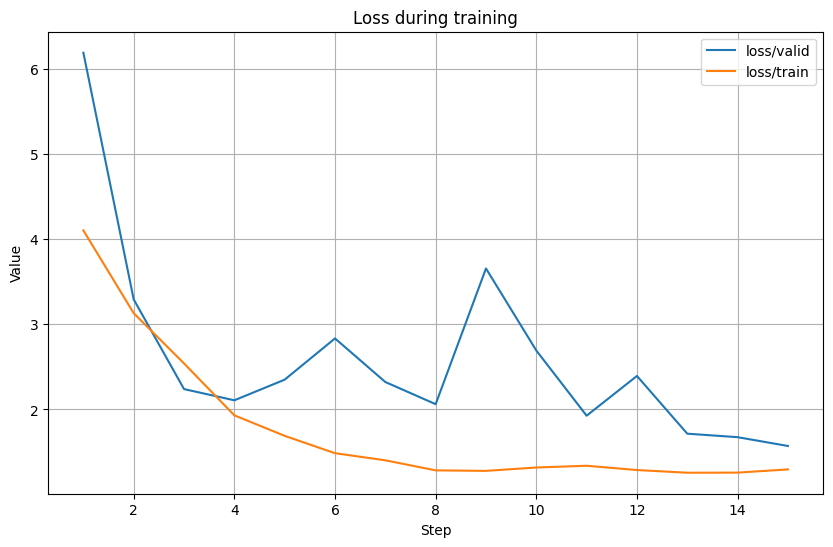

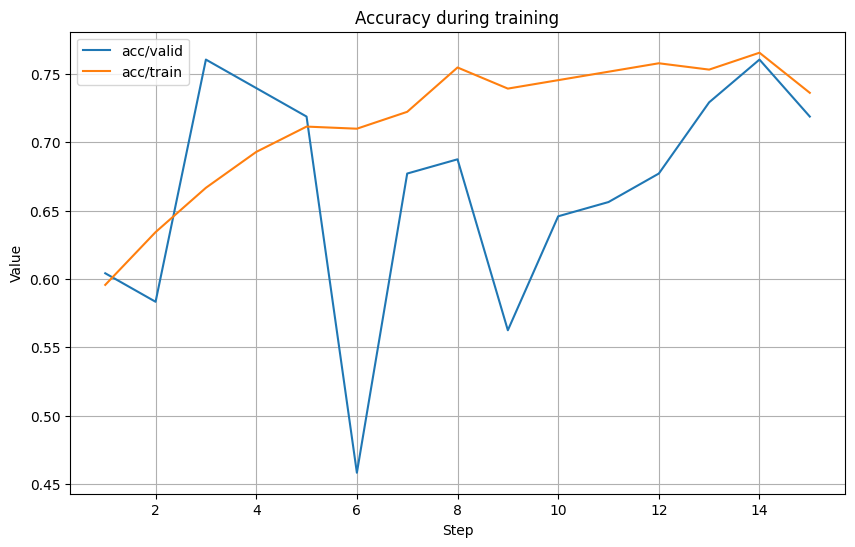

In [2]:

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/augmentation/full_dataset/fbank/1986/tb_logs/events.out.tfevents.1745559744.ul-val-pr-gpu05.l.ul.ca.2519578.0"
plot_training(event_file)



## Transfer Learning: Finetuning the Pretrained ECAPA-TDNN + Data Augmentation

### hparams file

In [26]:
%%file hparams_ecapatdnn_pretrainedaugmented_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/pretrainedaugmented/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

####################### Data Augmentation ####################################
# Speed perturbation
speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: [95, 100, 105]

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: 0
    drop_freq_high: 1
    drop_freq_count_low: 1
    drop_freq_count_high: 3
    drop_freq_width: 0.05

# Time drop: randomly drops a number of temporal chunks.
drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: 1000
    drop_length_high: 2000
    drop_count_low: 1
    drop_count_high: 5

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    min_augmentations: 3
    max_augmentations: 3
    augment_prob: 1.0
    augmentations: [
        !ref <speed_perturb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

####################### Training ####################################

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>

# Load pretrained embedding module
# Note: in this case, we pre-train with the ECAPA-TDNN model trained on voxceleb
# for speaker-id (this leads to a performance improvement).
embedding_model_path: speechbrain/spkrec-ecapa-voxceleb/embedding_model.ckpt

# Pretrained ECAPA embeddings from SpeakerID on VoxCeleb
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        embedding_model: !ref <embedding_model>
    paths:
        embedding_model: !ref <embedding_model_path>


Overwriting hparams_ecapatdnn_pretrainedaugmented_fbanks.yaml


### train file

In [28]:
%%file train_ecapatdnn_pretrainedaugmented_fbanks.py

#!/usr/bin/env python3
import os
import sys

import torchaudio
import torch
# from common_language_prepare import prepare_common_language
from hyperpyyaml import load_hyperpyyaml

import speechbrain as sb
from speechbrain.utils.logger import get_logger
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np

"""Recipe for training a LID system with CommonLanguage.

To run this recipe, do the following:
> python train.py hparams/train_ecapa_tdnn.yaml

Author
------
 * Mirco Ravanelli 2021
 * Pavlo Ruban 2021
"""

# logger = get_logger(__name__)


# Brain class for Language ID training
class DetectorBrain(sb.Brain):
    def prepare_features(self, wavs, stage):
        """Prepare the features for computation, including augmentation.

        Arguments
        ---------
        wavs : tuple
            Input signals (tensor) and their relative lengths (tensor).
        stage : sb.Stage
            The current stage of training.

        Returns
        -------
        feats : torch.Tensor
            Computed features.
        lens : torch.Tensor
            The length of the corresponding features.
        """
        wavs, lens = wavs
        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)

        # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm_input(feats, lens)

        return feats, lens

    def compute_forward(self, batch, stage):
        """Runs all the computation of that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            torch.Tensor that contains the posterior probabilities over the N classes.
        """

        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)

        # Compute features, embeddings and output
        feats, lens = self.prepare_features(batch.sig, stage)
        embeddings = self.modules.embedding_model(feats)
        outputs = self.modules.classifier(embeddings)

        return outputs, lens

    def compute_objectives(self, inputs, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        inputs : tensors
            The output tensors from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        predictions, lens = inputs

        targets = batch.detection_id_encoded.data
        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            targets = self.hparams.wav_augment.replicate_labels(targets)
            
        loss = self.hparams.compute_cost(predictions, targets)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, targets, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = targets.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)
        if stage == sb.Stage.TEST:
            # print('test y_true= ', y_true)
            # print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=targets, lengths=lens
        )

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_common_language` to have been called before this,
    so that the `train.csv`, `valid.csv`,  and `test.csv` manifest files
    are available.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "dev" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'lang01': 0, 'lang02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, _ = torchaudio.load(wav)
        sig = sig.transpose(0, 1).squeeze(1)

        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }

    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":
    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test" and label_encoder
    datasets, label_encoder = dataio_prep(hparams)

    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    # print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_options"],
        valid_loader_kwargs=hparams["test_dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["test_dataloader_options"],
    )
    

Overwriting train_ecapatdnn_pretrainedaugmented_fbanks.py


In [29]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/pretrainedaugmented/full_dataset/fbank/1986
import sys
# Run Training
!{sys.executable} train_ecapatdnn_pretrainedaugmented_fbanks.py hparams_ecapatdnn_pretrainedaugmented_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/pretrainedaugmented/full_dataset/fbank/1986
2025-04-25 02:14:04.981377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 02:14:05.006350: E external/local_xla/xla/stre

### training output log:

```
Epoch: 1, lr: 1.00e-04 - train loss: 4.15, train acc: 5.85e-01 - valid loss: 6.00, valid acc: 5.31e-01, valid error: 4.69e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.06, train acc: 6.47e-01 - valid loss: 4.02, valid acc: 5.83e-01, valid error: 4.17e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.47, train acc: 6.71e-01 - valid loss: 2.41, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 4, lr: 8.07e-05 - train loss: 1.96, train acc: 6.94e-01 - valid loss: 2.81, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 5, lr: 7.43e-05 - train loss: 1.91, train acc: 6.85e-01 - valid loss: 1.89, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 6, lr: 6.79e-05 - train loss: 1.70, train acc: 7.02e-01 - valid loss: 1.48, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.56, train acc: 7.18e-01 - valid loss: 1.96, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 8, lr: 5.50e-05 - train loss: 1.34, train acc: 7.59e-01 - valid loss: 1.56, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.50, train acc: 7.22e-01 - valid loss: 3.00, valid acc: 6.46e-01, valid error: 3.54e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.58, train acc: 7.41e-01 - valid loss: 1.65, valid acc: 8.12e-01, valid error: 1.88e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.30, train acc: 7.61e-01 - valid loss: 1.54, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.39, train acc: 7.52e-01 - valid loss: 2.03, valid acc: 6.67e-01, valid error: 3.33e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.32, train acc: 7.52e-01 - valid loss: 1.36, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 14, lr: 1.64e-05 - train loss: 1.28, train acc: 7.56e-01 - valid loss: 2.20, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 15, lr: 1.00e-05 - train loss: 1.32, train acc: 7.33e-01 - valid loss: 1.15, valid acc: 8.12e-01, valid error: 1.88e-01
Epoch loaded: 15, 
 Per Class Accuracy: 
0: 0.896
1: 0.895, 
 Confusion Matrix: 
[[43  5]
 [ 4 34]]
 - test loss: 1.06, test acc: 8.95e-01, test error: 1.05e-01
```

'PD' => 0

'HC' => 1


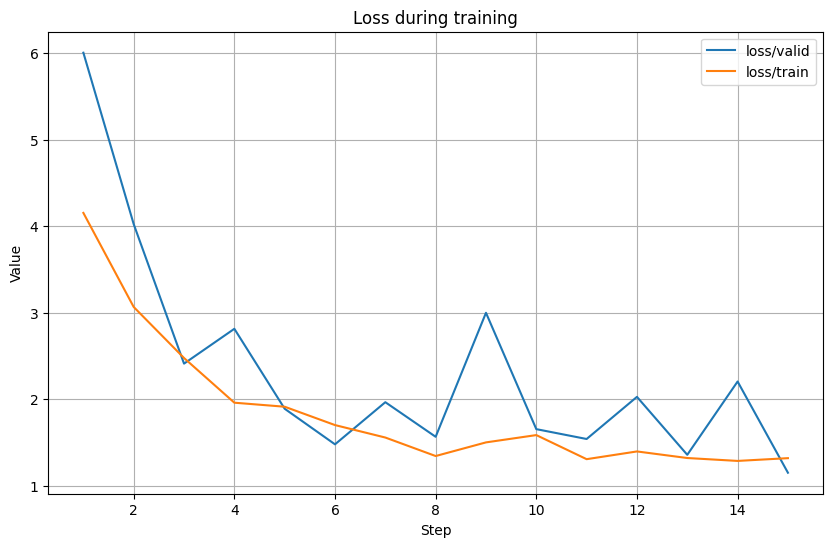

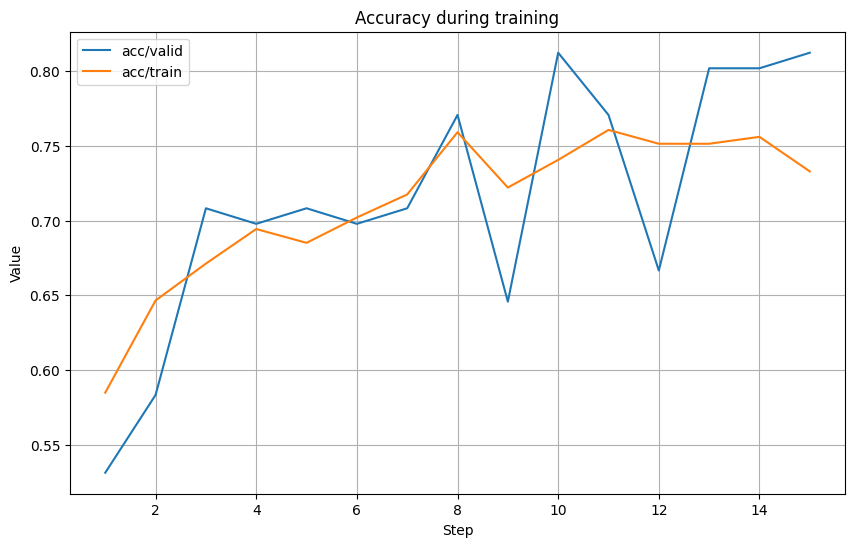

In [3]:

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/pretrainedaugmented/full_dataset/fbank/1986/tb_logs/events.out.tfevents.1745561650.ul-val-pr-gpu05.l.ul.ca.2524882.0"
plot_training(event_file)



### Results of ECAPA-TDNN & Xvector Models on full dataset

| model | Test Accuracy% | PD Acc% | HC Acc% | Error Rate% |
| -------------- | --- | --- | --- | --- |
| Simple MLP |  73.3 | 89.6 | 50.0 | 27.9 |
| Xvector from scratch | 93.8 | 91.7% | 94.7% | 6.98 |
| Xvector pretrained | 100 | 100 | 100 | 0.0 |
| ECAPATDNN from scratch | 80.2 | 93.8 | 63.2 | 19.8 |
| ECAPATDNN pretrained | 87.2 | 97.9 | 73.7 | 12.8 |
| ECAPATDNN pretrained + Data Augmentation | 89.5 | 89.6 | 89.5 | 10.5 |


## ECAPA-TDNN from scratch on vowels data

### haparams file

In [30]:
%%file hparams_fromscratch_vowels_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/vowels/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train_vowels.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid_vowels.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test_vowels.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch_vowels_ecapatdnn_fbanks.yaml


### training output log

In [31]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/vowels/fbank/1986

# Run Training
!{sys.executable} train_ecapatdnn_fbanks.py hparams_fromscratch_vowels_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/vowels/fbank/1986
2025-04-25 02:51:01.023068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 02:51:01.046711: E external/local_xla/xla/stream_executor/cu

### output log:

```
Epoch: 1, lr: 1.00e-04 - train loss: 3.86, train acc: 7.00e-01 - valid loss: 6.60e-01, valid acc: 9.67e-01, valid error: 3.33e-02
Epoch: 2, lr: 9.36e-05 - train loss: 3.07, train acc: 6.79e-01 - valid loss: 9.01e-01, valid acc: 8.83e-01, valid error: 1.17e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.69, train acc: 7.21e-01 - valid loss: 8.65e-01, valid acc: 9.33e-01, valid error: 6.67e-02
Epoch: 4, lr: 8.07e-05 - train loss: 2.34, train acc: 7.24e-01 - valid loss: 8.19e-01, valid acc: 9.33e-01, valid error: 6.67e-02
Epoch: 5, lr: 7.43e-05 - train loss: 2.04, train acc: 7.41e-01 - valid loss: 7.43e-01, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 6, lr: 6.79e-05 - train loss: 2.19, train acc: 7.00e-01 - valid loss: 7.05e-01, valid acc: 9.00e-01, valid error: 1.00e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.71, train acc: 7.59e-01 - valid loss: 4.43e-01, valid acc: 9.33e-01, valid error: 6.67e-02
Epoch: 8, lr: 5.50e-05 - train loss: 1.57, train acc: 7.41e-01 - valid loss: 3.66e-01, valid acc: 9.67e-01, valid error: 3.33e-02
Epoch: 9, lr: 4.86e-05 - train loss: 1.53, train acc: 7.18e-01 - valid loss: 5.15e-01, valid acc: 9.33e-01, valid error: 6.67e-02
Epoch: 10, lr: 4.21e-05 - train loss: 1.32, train acc: 7.47e-01 - valid loss: 3.41e-01, valid acc: 9.83e-01, valid error: 1.67e-02
Epoch: 11, lr: 3.57e-05 - train loss: 1.19, train acc: 7.88e-01 - valid loss: 5.87e-01, valid acc: 9.00e-01, valid error: 1.00e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.28, train acc: 7.59e-01 - valid loss: 4.01e-01, valid acc: 9.33e-01, valid error: 6.67e-02
Epoch: 13, lr: 2.29e-05 - train loss: 1.11, train acc: 7.65e-01 - valid loss: 3.14e-01, valid acc: 9.67e-01, valid error: 3.33e-02
Epoch: 14, lr: 1.64e-05 - train loss: 1.35, train acc: 7.47e-01 - valid loss: 5.04e-01, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.18, train acc: 7.53e-01 - valid loss: 2.94e-01, valid acc: 9.67e-01, valid error: 3.33e-02
Epoch loaded: 10, 
 Per Class Accuracy: 
0: 0.650
1: 0.967, 
 Confusion Matrix: 
[[13  7]
 [ 1 29]]
 - test loss: 1.48, test acc: 8.40e-01, test error: 1.60e-01
```

'HC' => 0

'PD' => 1


## ECAPA-TDNN from scratch on vowel-a data

### haparams file

In [33]:
%%file hparams_fromscratch_vowela_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/vowela/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train_vowela.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid_vowela.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test_vowela.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Overwriting hparams_fromscratch_vowela_ecapatdnn_fbanks.yaml


In [34]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/vowela/fbank/1986

# Run Training
!{sys.executable} train_ecapatdnn_fbanks.py hparams_fromscratch_vowela_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/vowela/fbank/1986
2025-04-25 02:57:48.979760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 02:57:49.004859: E external/local_xla/xla/stream_executor/cu

### training output log

```
Epoch: 1, lr: 1.00e-04 - train loss: 7.16, train acc: 5.59e-01 - valid loss: 1.69, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 2, lr: 9.36e-05 - train loss: 5.24, train acc: 5.88e-01 - valid loss: 3.34, valid acc: 7.50e-01, valid error: 2.50e-01
Epoch: 3, lr: 8.71e-05 - train loss: 3.65, train acc: 6.76e-01 - valid loss: 4.14, valid acc: 4.17e-01, valid error: 5.83e-01
Epoch: 4, lr: 8.07e-05 - train loss: 3.76, train acc: 6.18e-01 - valid loss: 2.95, valid acc: 6.67e-01, valid error: 3.33e-01
Epoch: 5, lr: 7.43e-05 - train loss: 3.23, train acc: 6.76e-01 - valid loss: 2.09, valid acc: 6.67e-01, valid error: 3.33e-01
Epoch: 6, lr: 6.79e-05 - train loss: 3.58, train acc: 7.06e-01 - valid loss: 4.34e-01, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 7, lr: 6.14e-05 - train loss: 2.86, train acc: 7.06e-01 - valid loss: 1.20, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 8, lr: 5.50e-05 - train loss: 3.71, train acc: 6.47e-01 - valid loss: 1.43, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 9, lr: 4.86e-05 - train loss: 2.90, train acc: 7.06e-01 - valid loss: 2.23, valid acc: 7.50e-01, valid error: 2.50e-01
Epoch: 10, lr: 4.21e-05 - train loss: 2.58, train acc: 7.65e-01 - valid loss: 1.87, valid acc: 7.50e-01, valid error: 2.50e-01
Epoch: 11, lr: 3.57e-05 - train loss: 2.20, train acc: 7.65e-01 - valid loss: 1.38, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 12, lr: 2.93e-05 - train loss: 1.85, train acc: 8.24e-01 - valid loss: 9.01e-01, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 13, lr: 2.29e-05 - train loss: 2.93, train acc: 7.06e-01 - valid loss: 1.27, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 14, lr: 1.64e-05 - train loss: 2.33, train acc: 7.35e-01 - valid loss: 1.24, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 15, lr: 1.00e-05 - train loss: 2.07, train acc: 7.94e-01 - valid loss: 1.13, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch loaded: 12, 
 Per Class Accuracy: 
0: 1.000
1: 0.500, 
 Confusion Matrix: 
[[6 0]
 [2 2]]
 - test loss: 1.93, test acc: 8.00e-01, test error: 2.00e-01
```

'PD' => 0

'HC' => 1


## ECAPA-TDNN from scratch on phrases data

### haparams file

In [35]:
%%file hparams_fromscratch_phrases_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/phrases/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train_phrases.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid_phrases.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test_phrases.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 192 # dimensionality of the embeddings
emb_channels: [1024, 1024, 1024, 1024, 3072]
emb_attention_channels: 128

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch_phrases_ecapatdnn_fbanks.yaml


In [ ]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch/phrases/fbank/1986

# Run Training
!{sys.executable} train_ecapatdnn_fbanks.py hparams_fromscratch_phrases_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### training output log

```
Epoch: 1, lr: 1.00e-04 - train loss: 3.73, train acc: 6.90e-01 - valid loss: 8.56e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 2, lr: 9.36e-05 - train loss: 3.06, train acc: 7.15e-01 - valid loss: 4.89e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 3, lr: 8.71e-05 - train loss: 3.37, train acc: 6.69e-01 - valid loss: 2.26e-01, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 4, lr: 8.07e-05 - train loss: 2.19, train acc: 7.60e-01 - valid loss: 3.31, valid acc: 7.37e-01, valid error: 2.63e-01
Epoch: 5, lr: 7.43e-05 - train loss: 2.24, train acc: 7.36e-01 - valid loss: 2.48, valid acc: 7.63e-01, valid error: 2.37e-01
Epoch: 6, lr: 6.79e-05 - train loss: 2.53, train acc: 7.02e-01 - valid loss: 1.55, valid acc: 8.68e-01, valid error: 1.32e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.95, train acc: 7.52e-01 - valid loss: 1.05, valid acc: 8.95e-01, valid error: 1.05e-01
Epoch: 8, lr: 5.50e-05 - train loss: 2.34, train acc: 7.11e-01 - valid loss: 6.27e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 9, lr: 4.86e-05 - train loss: 1.85, train acc: 7.36e-01 - valid loss: 9.70e-01, valid acc: 9.21e-01, valid error: 7.89e-02
Epoch: 10, lr: 4.21e-05 - train loss: 1.70, train acc: 7.36e-01 - valid loss: 4.01e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 11, lr: 3.57e-05 - train loss: 1.63, train acc: 7.52e-01 - valid loss: 6.28e-01, valid acc: 9.74e-01, valid error: 2.63e-02
Epoch: 12, lr: 2.93e-05 - train loss: 1.30, train acc: 7.60e-01 - valid loss: 4.85e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 13, lr: 2.29e-05 - train loss: 1.60, train acc: 7.07e-01 - valid loss: 5.01e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 14, lr: 1.64e-05 - train loss: 1.19, train acc: 7.60e-01 - valid loss: 3.51e-01, valid acc: 9.47e-01, valid error: 5.26e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.22, train acc: 7.85e-01 - valid loss: 5.36e-01, valid acc: 9.21e-01, valid error: 7.89e-02
Epoch loaded: 3, 
 Per Class Accuracy: 
0: 0.933
1: 1.000, 
 Confusion Matrix: 
[[14  1]
 [ 0 18]]
 - test loss: 2.24e-01, test acc: 9.71e-01, test error: 3.03e-02
```

'HC' => 0

'PD' => 1


## Hyper-parameter Tuning

## 128embdim/ emb_channels[512, 512, 512, 512, 1024]/ 64emb_attention_channels

In [4]:
%%file hparams_fromscratch128_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch128/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 2
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
emb_channels: [512, 512, 512, 512, 1024]
emb_attention_channels: 64

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch128_ecapatdnn_fbanks.yaml


In [ ]:

!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch128/full_dataset/fbank/1986

# Run Training
!{sys.executable} train_ecapatdnn_fbanks.py hparams_fromscratch128_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 4.50, train acc: 6.11e-01 - valid loss: 4.00, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.59, train acc: 6.34e-01 - valid loss: 4.02, valid acc: 7.08e-01, valid error: 2.92e-01
Epoch: 3, lr: 8.71e-05 - train loss: 3.14, train acc: 6.54e-01 - valid loss: 2.90, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.85, train acc: 6.88e-01 - valid loss: 2.65, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 5, lr: 7.43e-05 - train loss: 2.60, train acc: 6.90e-01 - valid loss: 1.64, valid acc: 8.54e-01, valid error: 1.46e-01
Epoch: 6, lr: 6.79e-05 - train loss: 2.22, train acc: 7.02e-01 - valid loss: 1.53, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 7, lr: 6.14e-05 - train loss: 2.06, train acc: 6.88e-01 - valid loss: 1.60, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 8, lr: 5.50e-05 - train loss: 1.69, train acc: 7.41e-01 - valid loss: 1.37, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.63, train acc: 7.25e-01 - valid loss: 1.49, valid acc: 7.50e-01, valid error: 2.50e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.68, train acc: 7.38e-01 - valid loss: 1.07, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.46, train acc: 7.48e-01 - valid loss: 1.78, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.55, train acc: 7.44e-01 - valid loss: 1.03, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.51, train acc: 7.47e-01 - valid loss: 6.16e-01, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch: 14, lr: 1.64e-05 - train loss: 1.57, train acc: 7.55e-01 - valid loss: 7.38e-01, valid acc: 9.27e-01, valid error: 7.29e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.57, train acc: 7.39e-01 - valid loss: 7.57e-01, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch loaded: 13, 
 Per Class Accuracy: 
0: 0.958
1: 0.789, 
 Confusion Matrix: 
[[46  2]
 [ 8 30]]
 - test loss: 1.15, test acc: 8.84e-01, test error: 1.16e-01
```

'PD' => 0

'HC' => 1


## 64embdim/ emb_channels[256, 256, 256, 256, 512]/ 32emb_attention_channels

In [5]:
%%file hparams_fromscratch64_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch64/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 4
n_classes: 2
emb_dim: 64 # dimensionality of the embeddings
emb_channels: [256, 256, 256, 256, 512]
emb_attention_channels: 32

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch64_ecapatdnn_fbanks.yaml


In [ ]:
rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch64/full_dataset/fbank/1986
# Run Training
python train_models/train_ecapatdnn_fbanks.py train_models/hparams_fromscratch64_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 3.66, train acc: 7.11e-01 - valid loss: 3.24, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 2, lr: 9.36e-05 - train loss: 2.36, train acc: 8.04e-01 - valid loss: 2.80, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 3, lr: 8.71e-05 - train loss: 1.96, train acc: 8.43e-01 - valid loss: 2.14, valid acc: 8.54e-01, valid error: 1.46e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.01, train acc: 8.49e-01 - valid loss: 1.06, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 5, lr: 7.43e-05 - train loss: 1.76, train acc: 8.64e-01 - valid loss: 1.31, valid acc: 8.75e-01, valid error: 1.25e-01
Epoch: 6, lr: 6.79e-05 - train loss: 1.64, train acc: 8.63e-01 - valid loss: 1.68, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 7, lr: 6.14e-05 - train loss: 1.71, train acc: 8.60e-01 - valid loss: 6.62e-01, valid acc: 9.58e-01, valid error: 4.17e-02
Epoch: 8, lr: 5.50e-05 - train loss: 1.35, train acc: 8.97e-01 - valid loss: 1.39, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.60, train acc: 8.72e-01 - valid loss: 6.08e-01, valid acc: 9.48e-01, valid error: 5.21e-02
Epoch: 10, lr: 4.21e-05 - train loss: 1.15, train acc: 9.21e-01 - valid loss: 5.15e-01, valid acc: 9.58e-01, valid error: 4.17e-02
Epoch: 11, lr: 3.57e-05 - train loss: 1.02, train acc: 9.18e-01 - valid loss: 2.94e-01, valid acc: 9.79e-01, valid error: 2.08e-02
Epoch: 12, lr: 2.93e-05 - train loss: 1.29, train acc: 9.12e-01 - valid loss: 4.39e-01, valid acc: 9.69e-01, valid error: 3.12e-02
Epoch: 13, lr: 2.29e-05 - train loss: 1.17, train acc: 9.09e-01 - valid loss: 7.60e-01, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch: 14, lr: 1.64e-05 - train loss: 7.81e-01, train acc: 9.41e-01 - valid loss: 3.78e-01, valid acc: 9.79e-01, valid error: 2.08e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.13, train acc: 9.18e-01 - valid loss: 7.79e-01, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch loaded: 14, 
 Per Class Accuracy: 
0: 1.000
1: 0.895, 
 Confusion Matrix: 
[[48  0]
 [ 4 34]]
 - test loss: 7.88e-01, test acc: 9.55e-01, test error: 4.65e-02
```

'PD' => 0

'HC' => 1


## 32embdim/ emb_channels[128, 128, 128, 128, 256]/ 16emb_attention_channels

In [8]:
%%file hparams_fromscratch32_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch32/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 4
n_classes: 2
emb_dim: 32 # dimensionality of the embeddings
emb_channels: [128, 128, 128, 128, 256]
emb_attention_channels: 16

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Overwriting hparams_fromscratch32_ecapatdnn_fbanks.yaml


In [ ]:
rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch32/full_dataset/fbank/1986
# Run Training
python train_models/train_ecapatdnn_fbanks.py train_models/hparams_fromscratch32_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 3.59, train acc: 7.11e-01 - valid loss: 1.49, valid acc: 8.85e-01, valid error: 1.15e-01
Epoch: 2, lr: 9.36e-05 - train loss: 2.14, train acc: 8.13e-01 - valid loss: 1.40, valid acc: 8.75e-01, valid error: 1.25e-01
Epoch: 3, lr: 8.71e-05 - train loss: 1.80, train acc: 8.41e-01 - valid loss: 1.94, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.01, train acc: 8.41e-01 - valid loss: 8.85e-01, valid acc: 9.27e-01, valid error: 7.29e-02
Epoch: 5, lr: 7.43e-05 - train loss: 1.67, train acc: 8.63e-01 - valid loss: 7.38e-01, valid acc: 9.48e-01, valid error: 5.21e-02
Epoch: 6, lr: 6.79e-05 - train loss: 1.87, train acc: 8.44e-01 - valid loss: 9.15e-01, valid acc: 9.27e-01, valid error: 7.29e-02
Epoch: 7, lr: 6.14e-05 - train loss: 1.62, train acc: 8.56e-01 - valid loss: 3.83e-01, valid acc: 9.79e-01, valid error: 2.08e-02
Epoch: 8, lr: 5.50e-05 - train loss: 1.41, train acc: 8.92e-01 - valid loss: 4.01e-01, valid acc: 9.69e-01, valid error: 3.12e-02
Epoch: 9, lr: 4.86e-05 - train loss: 1.69, train acc: 8.58e-01 - valid loss: 4.32e-01, valid acc: 9.58e-01, valid error: 4.17e-02
Epoch: 10, lr: 4.21e-05 - train loss: 1.26, train acc: 8.94e-01 - valid loss: 6.79e-01, valid acc: 9.27e-01, valid error: 7.29e-02
Epoch: 11, lr: 3.57e-05 - train loss: 1.19, train acc: 8.97e-01 - valid loss: 3.61e-01, valid acc: 9.69e-01, valid error: 3.12e-02
Epoch: 12, lr: 2.93e-05 - train loss: 1.47, train acc: 8.94e-01 - valid loss: 2.16e-01, valid acc: 9.79e-01, valid error: 2.08e-02
Epoch: 13, lr: 2.29e-05 - train loss: 1.25, train acc: 8.98e-01 - valid loss: 4.72e-01, valid acc: 9.79e-01, valid error: 2.08e-02
Epoch: 14, lr: 1.64e-05 - train loss: 9.29e-01, train acc: 9.20e-01 - valid loss: 5.53e-01, valid acc: 9.58e-01, valid error: 4.17e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.20, train acc: 9.06e-01 - valid loss: 6.55e-01, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch loaded: 13, 
 Per Class Accuracy: 
0: 1.000
1: 0.947, 
 Confusion Matrix: 
[[48  0]
 [ 2 36]]
 - test loss: 4.91e-01, test acc: 9.77e-01, test error: 2.33e-02
```

'PD' => 0

'HC' => 1


## 16embdim/ emb_channels[64, 64, 64, 64, 128]/ 8emb_attention_channels

In [9]:
%%file hparams_fromscratch16_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch16/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 4
n_classes: 2
emb_dim: 16 # dimensionality of the embeddings
emb_channels: [64, 64, 64, 64, 128]
emb_attention_channels: 8

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch16_ecapatdnn_fbanks.yaml


In [ ]:
rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch16/full_dataset/fbank/1986
# Run Training
python train_models/train_ecapatdnn_fbanks.py train_models/hparams_fromscratch16_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 4.78, train acc: 6.79e-01 - valid loss: 4.18, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.01, train acc: 7.92e-01 - valid loss: 3.56, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.97, train acc: 8.01e-01 - valid loss: 2.34, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.70, train acc: 8.29e-01 - valid loss: 2.28, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 5, lr: 7.43e-05 - train loss: 2.67, train acc: 8.13e-01 - valid loss: 1.85, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 6, lr: 6.79e-05 - train loss: 2.51, train acc: 8.38e-01 - valid loss: 1.82, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 7, lr: 6.14e-05 - train loss: 2.45, train acc: 8.33e-01 - valid loss: 1.63, valid acc: 8.75e-01, valid error: 1.25e-01
Epoch: 8, lr: 5.50e-05 - train loss: 2.17, train acc: 8.73e-01 - valid loss: 1.84, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 9, lr: 4.86e-05 - train loss: 2.29, train acc: 8.44e-01 - valid loss: 1.20, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch: 10, lr: 4.21e-05 - train loss: 1.83, train acc: 8.73e-01 - valid loss: 1.40, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.80, train acc: 8.73e-01 - valid loss: 1.14, valid acc: 9.27e-01, valid error: 7.29e-02
Epoch: 12, lr: 2.93e-05 - train loss: 1.98, train acc: 8.72e-01 - valid loss: 1.68, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.91, train acc: 8.66e-01 - valid loss: 1.13, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch: 14, lr: 1.64e-05 - train loss: 1.64, train acc: 8.92e-01 - valid loss: 1.18, valid acc: 9.58e-01, valid error: 4.17e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.80, train acc: 8.80e-01 - valid loss: 9.74e-01, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch loaded: 14, 
 Per Class Accuracy: 
0: 1.000
1: 0.947, 
 Confusion Matrix: 
[[48  0]
 [ 2 36]]
 - test loss: 5.10e-01, test acc: 9.77e-01, test error: 2.33e-02
'PD' => 0
'HC' => 1
```

## 8embdim/ emb_channels[32, 32, 32, 32, 64]/ 4emb_attention_channels

In [10]:
%%file hparams_fromscratch8_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch8/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 4
n_classes: 2
emb_dim: 8 # dimensionality of the embeddings
emb_channels: [32, 32, 32, 32, 64]
emb_attention_channels: 4

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch8_ecapatdnn_fbanks.yaml


In [ ]:
rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch8/full_dataset/fbank/1986
# Run Training
python train_models/train_ecapatdnn_fbanks.py train_models/hparams_fromscratch8_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 4.98, train acc: 6.08e-01 - valid loss: 3.15, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.59, train acc: 6.99e-01 - valid loss: 2.16, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.81, train acc: 7.48e-01 - valid loss: 1.99, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.40, train acc: 7.82e-01 - valid loss: 1.76, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 5, lr: 7.43e-05 - train loss: 2.14, train acc: 7.98e-01 - valid loss: 1.61, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 6, lr: 6.79e-05 - train loss: 2.28, train acc: 7.58e-01 - valid loss: 1.31, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 7, lr: 6.14e-05 - train loss: 1.90, train acc: 8.06e-01 - valid loss: 1.35, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch: 8, lr: 5.50e-05 - train loss: 1.92, train acc: 8.15e-01 - valid loss: 1.34, valid acc: 8.96e-01, valid error: 1.04e-01
Epoch: 9, lr: 4.86e-05 - train loss: 1.91, train acc: 8.06e-01 - valid loss: 1.40, valid acc: 8.65e-01, valid error: 1.35e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.72, train acc: 8.35e-01 - valid loss: 8.38e-01, valid acc: 9.27e-01, valid error: 7.29e-02
Epoch: 11, lr: 3.57e-05 - train loss: 1.63, train acc: 8.47e-01 - valid loss: 9.56e-01, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch: 12, lr: 2.93e-05 - train loss: 1.68, train acc: 8.52e-01 - valid loss: 9.75e-01, valid acc: 9.06e-01, valid error: 9.38e-02
Epoch: 13, lr: 2.29e-05 - train loss: 1.49, train acc: 8.46e-01 - valid loss: 8.66e-01, valid acc: 9.38e-01, valid error: 6.25e-02
Epoch: 14, lr: 1.64e-05 - train loss: 1.44, train acc: 8.63e-01 - valid loss: 1.00, valid acc: 9.06e-01, valid error: 9.38e-02
Epoch: 15, lr: 1.00e-05 - train loss: 1.61, train acc: 8.44e-01 - valid loss: 8.30e-01, valid acc: 9.17e-01, valid error: 8.33e-02
Epoch loaded: 13, 
 Per Class Accuracy: 
0: 1.000
1: 0.947, 
 Confusion Matrix: 
[[48  0]
 [ 2 36]]
 - test loss: 4.82e-01, test acc: 9.77e-01, test error: 2.33e-02
'PD' => 0
'HC' => 1
```

## 4embdim/ emb_channels[16, 16, 16, 16, 32]/ 2emb_attention_channels

In [12]:
%%file hparams_fromscratch4_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch4/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 4
n_classes: 2
emb_dim: 4 # dimensionality of the embeddings
emb_channels: [16, 16, 16, 16, 32]
emb_attention_channels: 2

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch4_ecapatdnn_fbanks.yaml


In [ ]:
rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch4/full_dataset/fbank/1986
# Run Training
python train_models/train_ecapatdnn_fbanks.py train_models/hparams_fromscratch4_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 6.72, train acc: 5.79e-01 - valid loss: 6.44, valid acc: 5.52e-01, valid error: 4.48e-01
Epoch: 2, lr: 9.36e-05 - train loss: 4.64, train acc: 6.96e-01 - valid loss: 5.45, valid acc: 6.25e-01, valid error: 3.75e-01
Epoch: 3, lr: 8.71e-05 - train loss: 4.08, train acc: 6.79e-01 - valid loss: 4.26, valid acc: 6.77e-01, valid error: 3.23e-01
Epoch: 4, lr: 8.07e-05 - train loss: 3.36, train acc: 7.44e-01 - valid loss: 3.94, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 5, lr: 7.43e-05 - train loss: 3.19, train acc: 7.31e-01 - valid loss: 2.66, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 6, lr: 6.79e-05 - train loss: 2.94, train acc: 7.45e-01 - valid loss: 2.49, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 7, lr: 6.14e-05 - train loss: 2.98, train acc: 7.59e-01 - valid loss: 2.46, valid acc: 7.92e-01, valid error: 2.08e-01
Epoch: 8, lr: 5.50e-05 - train loss: 2.50, train acc: 7.98e-01 - valid loss: 2.21, valid acc: 8.12e-01, valid error: 1.88e-01
Epoch: 9, lr: 4.86e-05 - train loss: 2.71, train acc: 7.79e-01 - valid loss: 1.80, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 10, lr: 4.21e-05 - train loss: 2.24, train acc: 7.79e-01 - valid loss: 2.23, valid acc: 8.12e-01, valid error: 1.88e-01
Epoch: 11, lr: 3.57e-05 - train loss: 2.10, train acc: 8.10e-01 - valid loss: 1.91, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 12, lr: 2.93e-05 - train loss: 2.52, train acc: 8.04e-01 - valid loss: 1.79, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 13, lr: 2.29e-05 - train loss: 2.26, train acc: 7.99e-01 - valid loss: 1.66, valid acc: 8.44e-01, valid error: 1.56e-01
Epoch: 14, lr: 1.64e-05 - train loss: 2.19, train acc: 8.13e-01 - valid loss: 1.66, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch: 15, lr: 1.00e-05 - train loss: 2.39, train acc: 7.81e-01 - valid loss: 1.77, valid acc: 8.33e-01, valid error: 1.67e-01
Epoch loaded: 13, 
 Per Class Accuracy: 
0: 1.000
1: 0.579, 
 Confusion Matrix: 
[[48  0]
 [16 22]]
 - test loss: 1.91, test acc: 8.18e-01, test error: 1.86e-01
'PD' => 0
'HC' => 1
```

## 2embdim/ emb_channels[8, 8, 8, 8, 16]/ 1emb_attention_channels

In [11]:
%%file hparams_fromscratch2_ecapatdnn_fbanks.yaml
# #################################
# Training ECAPA-TDNN embeddings for language identification (LID).
#
# Authors:
#  * Hwidong Na
#  * Mirco Ravanelli
#  * Pavlo Ruban
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Set up folders for reading from and writing to
# Dataset will be downloaded to the `data_folder`
data_folder: !PLACEHOLDER # e.g. /localscratch/common_voice_kpd/
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch2/full_dataset/fbank/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

####################### Training Parameters ####################################

# Feature parameters btw: 40 - 80
n_mels: 40
sample_rate: 16000
number_of_epochs: 15
batch_size: 4
n_classes: 2
emb_dim: 2 # dimensionality of the embeddings
emb_channels: [8, 8, 8, 8, 16]
emb_attention_channels: 1

# Dataloaders
num_workers: 4
drop_last: True
train_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    drop_last: !ref <drop_last>
    shuffle: True

test_dataloader_options:
    num_workers: !ref <num_workers>
    batch_size: !ref <batch_size>
    shuffle: True

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm_input: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

############################## Models ##########################################

# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined.

# Embedding Model
embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    channels: !ref <emb_channels>
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: !ref <emb_attention_channels>
    lin_neurons: !ref <emb_dim>

# Classifier based on cosine distance
classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.


modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    mean_var_norm_input: !ref <mean_var_norm_input>
    classifier: !ref <classifier>

# Additive Angular Margin
compute_cost: !new:speechbrain.nnet.losses.LogSoftmaxWrapper
    loss_fn: !new:speechbrain.nnet.losses.AdditiveAngularMargin
        margin: 0.2
        scale: 30

# Learning rates
lr: 0.0001
lr_final: 0.00001


# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002


# Linear lr decay
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

############################## Logging and Pretrainer ##########################

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        normalizer_input: !ref <mean_var_norm_input>
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        counter: !ref <epoch_counter>


Writing hparams_fromscratch2_ecapatdnn_fbanks.yaml


In [ ]:
rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/ECAPA-TDNN/fromscratch2/full_dataset/fbank/1986
# Run Training
python train_models/train_ecapatdnn_fbanks.py train_models/hparams_fromscratch2_ecapatdnn_fbanks.yaml  --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


### output log
```
Epoch: 1, lr: 1.00e-04 - train loss: 5.40, train acc: 5.77e-01 - valid loss: 3.66, valid acc: 7.19e-01, valid error: 2.81e-01
Epoch: 2, lr: 9.36e-05 - train loss: 3.66, train acc: 6.54e-01 - valid loss: 2.57, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 3, lr: 8.71e-05 - train loss: 2.91, train acc: 6.77e-01 - valid loss: 1.91, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 4, lr: 8.07e-05 - train loss: 2.70, train acc: 6.56e-01 - valid loss: 2.07, valid acc: 6.88e-01, valid error: 3.12e-01
Epoch: 5, lr: 7.43e-05 - train loss: 2.08, train acc: 7.16e-01 - valid loss: 2.62, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 6, lr: 6.79e-05 - train loss: 2.31, train acc: 7.05e-01 - valid loss: 1.71, valid acc: 8.12e-01, valid error: 1.88e-01
Epoch: 7, lr: 6.14e-05 - train loss: 2.03, train acc: 7.11e-01 - valid loss: 1.90, valid acc: 7.92e-01, valid error: 2.08e-01
Epoch: 8, lr: 5.50e-05 - train loss: 2.07, train acc: 6.99e-01 - valid loss: 1.99, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 9, lr: 4.86e-05 - train loss: 2.24, train acc: 7.05e-01 - valid loss: 1.18, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 10, lr: 4.21e-05 - train loss: 1.67, train acc: 7.41e-01 - valid loss: 1.32, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 11, lr: 3.57e-05 - train loss: 1.86, train acc: 7.22e-01 - valid loss: 2.01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 12, lr: 2.93e-05 - train loss: 1.78, train acc: 7.33e-01 - valid loss: 1.91, valid acc: 7.92e-01, valid error: 2.08e-01
Epoch: 13, lr: 2.29e-05 - train loss: 1.82, train acc: 7.22e-01 - valid loss: 1.86, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 14, lr: 1.64e-05 - train loss: 1.67, train acc: 7.41e-01 - valid loss: 1.44, valid acc: 8.23e-01, valid error: 1.77e-01
Epoch: 15, lr: 1.00e-05 - train loss: 1.66, train acc: 7.44e-01 - valid loss: 2.00, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch loaded: 14, 
 Per Class Accuracy: 
0: 0.979
1: 0.289, 
 Confusion Matrix: 
[[47  1]
 [27 11]]
 - test loss: 2.68, test acc: 6.70e-01, test error: 3.26e-01
'PD' => 0
'HC' => 1
```